In [ ]:
# Angela Santana # 301186111

# **Assignment 2**

Use python to create a VAE model that can classify anomalies in computer network data.
The dataset for training can be downloaded from:


1) Import all the necessary libraries, read the dataset using pandas and analyze the data. For data preparation phase, save the
“benign” and “attack” dataframe separately. Drop the “Label” column from the dataset and convert benign and attack
dataframes to numpy arrays. Now, split the data into test and train (use 75% observations for train set and the remaining 25%
for test set). Then, scale the train and test data using Standard Scalar. [10% marks].

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from scipy.stats import norm
import tensorflow as tf
from tensorflow import keras
from numpy.random import seed
seed(1)
import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

In [ ]:
#!pip install tensorflow==1.14.0
#!pip install keras== 2.2.4

In [ ]:
print('TensorFlow version: ', tf.__version__)
print('Keras version: ', keras.__version__)

TensorFlow version:  1.14.0
Keras version:  2.2.4-tf


In [ ]:
data = pd.read_csv("/content/drive/MyDrive/Python/CANADA/network_attack_data.csv") #load the dataset using pandas
data.head() # display the first 5 rows

,F_1,F_2,F_3,F_4,F_5,F_6,F_7,F_8,F_9,F_10,...,F_68,F_69,F_70,F_71,F_72,F_73,F_74,F_75,F_76,Label
0,109998919,4,3,525,0.0,520,0,131.25,259.177385,0,...,32,5735.0,0.0,5735.0,5735.0,110000000.0,0.0,110000000.0,110000000.0,1
1,109993343,4,3,531,0.0,520,0,132.75,258.218738,0,...,32,5437.0,0.0,5437.0,5437.0,110000000.0,0.0,110000000.0,110000000.0,1
2,109988359,4,3,535,0.0,520,0,133.75,257.597069,0,...,32,5505.0,0.0,5505.0,5505.0,110000000.0,0.0,110000000.0,110000000.0,1
3,109982960,4,3,530,0.0,520,0,132.50,258.376341,0,...,32,5303.0,0.0,5303.0,5303.0,110000000.0,0.0,110000000.0,110000000.0,1
4,109977744,4,3,530,0.0,520,0,132.50,258.376341,0,...,32,5356.0,0.0,5356.0,5356.0,110000000.0,0.0,110000000.0,110000000.0,1


In [ ]:
print(data.shape)

(28485, 77)


In [ ]:
data['Label'].value_counts() #count the number of classes (Normal and Fraud)

0    22987
1     5498
Name: Label, dtype: int64

In [ ]:
benign = data['Label']== 0 # create a dataframe for normal data
attack= data['Label']!= 0  # create dataframe for fraud data

data_benign = data[benign]
data_attack = data[attack]

print(f"benig count: {len(data_benign)}")
print(f"attack count: {len(data_attack)}")


benig count: 22987
attack count: 5498


In [ ]:
# convert dataframes to numpy arrays after dropping the label (class 0/1)
x_benign = data_benign.drop('Label',axis=1).values 
y_benign = data_benign['Label'].values

x_attack = data_attack.drop('Label',axis=1).values 
y_attack = data_attack['Label'].values

print(x_benign.shape, x_attack.shape)
print(y_benign.shape, y_attack.shape)

(22987, 76) (5498, 76)
(22987,) (5498,)


In [ ]:
#train-test split for normal train and test data
from sklearn.model_selection import train_test_split
x_benign_train, x_benign_test = train_test_split(x_benign, test_size=0.25, random_state=40)
print(x_benign_train.shape,  x_benign_test.shape)

(17240, 76) (5747, 76)


**Data Scaling using Min-Max scalar**

In [ ]:
import joblib
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler()
x_benign_tr_scaled= scaler.fit_transform(x_benign_train) # fit_transform on train data
x_benign_tst_scaled= scaler.transform(x_benign_test) # transform on test data
x_train_attack_scaled= scaler.transform(x_attack) # transform on test data

2) Set the following hyperparameter values: [5% marks].

* batch_size = 32
* original_dim = 76
* latent_dim = 10
* number of neurons in the hidden layers = 50
* epochs = 100


In [ ]:
batch_size = 32
original_dim = 76 ## number of features
latent_dim = 10
epochs = 100
epsilon_std = 1.0  #standard deviation of 1
hidden_layers = 50

3) Using Keras Functional API, define the encoder, sampling layer, the decoder and instantiate the VAE model. Note both the
encoder and decoder have two hidden layers each. [25% marks].


In [ ]:
x = keras.layers.Input(shape=(original_dim,)) #original_dim = 29 # number of input features
h1 = keras.layers.Dense(hidden_layers, activation='relu')(x) ## First hidden layer 
h2 = keras.layers.Dense(hidden_layers, activation='relu')(h1) ##Second hidden layer
z_mean = keras.layers.Dense(latent_dim)(h2) ### Latent layer
z_log_var = keras.layers.Dense(latent_dim)(h2) #latent_dim = 6

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [ ]:
K = keras.backend

def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0., stddev=epsilon_std)
    return z_mean + K.exp(z_log_var / 2) * epsilon

In [ ]:
#Latent layer
z = keras.layers.Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var]) #latent_dim = 10

In [ ]:
# we instantiate these layers separately so as to reuse them later
decoder_h1 = keras.layers.Dense(hidden_layers, activation='relu')
decoder_h2 = keras.layers.Dense(hidden_layers, activation='relu') 
h_decoded = decoder_h2(z)

decoder_mean = keras.layers.Dense(original_dim)  #original_dim = 29 ## number of features in the dataset
x_decoded_mean = decoder_mean(h_decoded)

4) Define the VAE loss function and compile the model using this loss metric and optimizer to be used is Adam. The learning rate
value must be 0.001. [10% marks].


In [ ]:
vae = keras.models.Model(x, x_decoded_mean) #input and output for the VAE

In [ ]:
def vae_loss(feature, reconstructed): # VAE loss= Reconstruction loss + KL divergence
    reconstruction_loss = keras.losses.binary_crossentropy(feature, reconstructed)
    kl_loss = - 0.5 * K.mean(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    return reconstruction_loss + kl_loss

5) Train the model with batch_size and epochs set above. Display the loss curve during training. Then save the encoder, decoder
and vae models (in .h5 format) using model.save. [15% marks].

In [ ]:
vae.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001),loss=vae_loss)
vae.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 76)]         0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 50)           3850        input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 50)           2550        dense[0][0]                      
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 10)           510         dense_1[0][0]                    
______________________________________________________________________________________________

**Train the VAE Model**

In [ ]:
history= vae.fit(x_benign_tr_scaled,x_benign_tr_scaled, verbose = 1, batch_size=batch_size, epochs=epochs,shuffle=True,validation_split=0.2) #unsupervised learning because only x values used (no y values or labels)

Train on 13792 samples, validate on 3448 samples
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/100
13792/13792 [==============================] - 1s 105us/sample - loss: 0.4985 - val_loss: 0.4316
Epoch 2/100
13792/13792 [==============================] - 1s 78us/sample - loss: 0.4060 - val_loss: 0.3891
Epoch 3/100
13792/13792 [==============================] - 1s 75us/sample - loss: 0.3745 - val_loss: 0.3633
Epoch 4/100
13792/13792 [==============================] - 1s 74us/sample - loss: 0.3528 - val_loss: 0.3518
Epoch 5/100
13792/13792 [==============================] - 1s 75us/sample - loss: 0.3392 - val_loss: 0.3353
Epoch 6/100
13792/13792 [==============================] - 1s 75us/sample - loss: 0.3255 - val_loss: 0.3250
Epoch 7/100
13792/13792 [==============================] - 1s 73us/sample - loss: 0.3185 - val_loss: 0.3183
Epoch 8/100
13792/13792 [==============================] - 1s 77us/sample - loss: 0.3126 - val_loss:

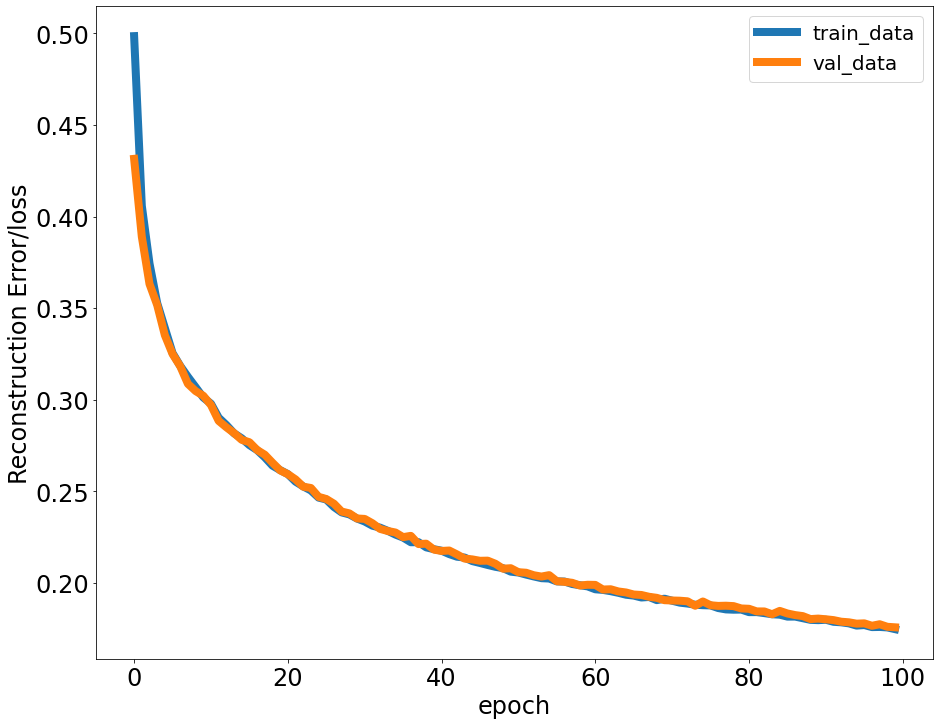

In [ ]:
# loss plot train-validation
import matplotlib as mpl

mpl.rcParams['font.size'] = 24
plt.rcParams["figure.figsize"] = (15,12)
plt.plot(history.history['loss'],linewidth = 8)
plt.plot(history.history['val_loss'],linewidth = 8)
#plt.title('model loss',fontsize = 24)
plt.ylabel('Reconstruction Error/loss',fontsize = 24)
plt.xlabel('epoch',fontsize = 24)
plt.legend(['train_data', 'val_data'], loc='best',fontsize = 20)
plt.show()

6) Make predictions on test data using model.predict, and visualize your plot comparing benign observations with attack
observations. Select the most appropriate threshold value by observing the graph and using trial and error approach. [20%
marks].

In [ ]:
from sklearn import metrics

pred1 = vae.predict(x_benign_tr_scaled) # predictions on train normal data
score1 = np.sqrt(metrics.mean_squared_error(pred1,x_benign_tr_scaled))

pred2 = vae.predict(x_benign_tst_scaled) # predictions on test normal data
score2 = np.sqrt(metrics.mean_squared_error(pred2,x_benign_tst_scaled))

pred3 = vae.predict(x_train_attack_scaled) # predictions on test fraud data
score3 = np.sqrt(metrics.mean_squared_error(pred3,x_train_attack_scaled))

print(f"benign_training_data Score (RMSE): {score1}")
print(f"benign_test_data_score Score (RMSE): {score2}")
print(f"attack_test_data_score (RMSE): {score3}")

benign_training_data Score (RMSE): 0.4847624913527298
benign_test_data_score Score (RMSE): 0.4801404283914548
attack_test_data_score (RMSE): 0.5298786239458301


**Combine the test data (benign) and attack data**

In [ ]:
tst_obs = x_benign_tst_scaled.copy() # create a copy of normal data and save in tst_obs
print(tst_obs.shape)
tst_obs = np.append(tst_obs, x_train_attack_scaled, axis=0) ##combine test normal and test fraud data
print(tst_obs.shape)
print(y_benign.shape)

(5747, 76)
(11245, 76)
(22987,)


**Make predictions using the VAE model**

In [ ]:
Y_obs = y_benign[0:5747].copy() # create a copy of normal labels and save in Y_obs
Y_obs  = np.append(Y_obs, y_attack, axis=0)
print(Y_obs.shape)

(11245,)


In [ ]:
test_preds=vae.predict(tst_obs)
mse_test = np.mean(np.power(tst_obs- test_preds, 2), axis=1)

In [ ]:
tst_error_data = pd.DataFrame({'recon_error': mse_test,'Class': Y_obs})

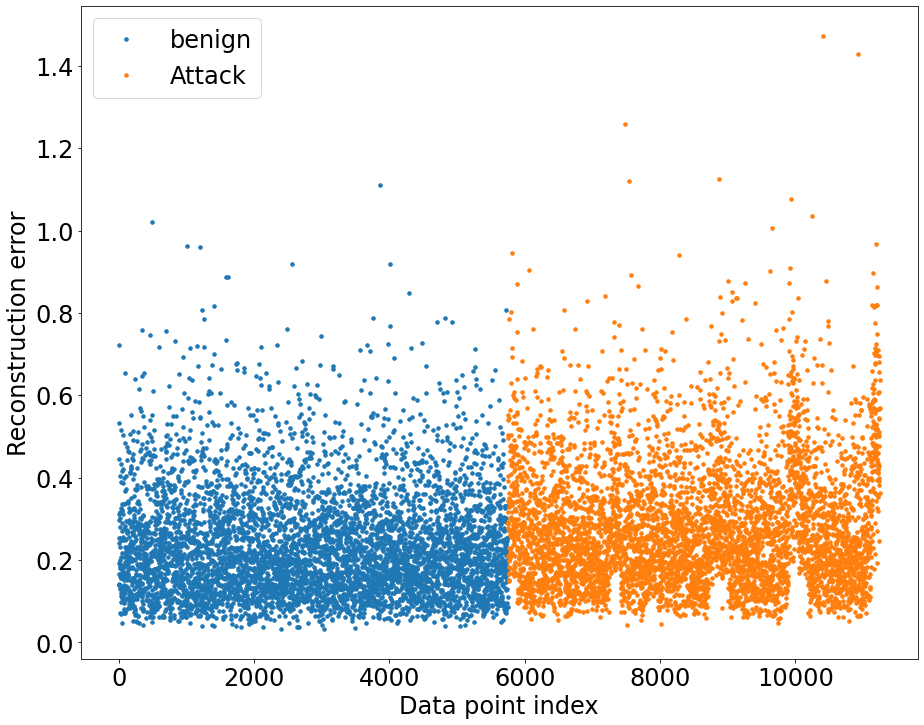

In [ ]:
#####RE for different classes of data

group1 = tst_error_data.groupby('Class')
fig, ax = plt.subplots()
for name, group in group1:
    ax.plot(group.index, group.recon_error, marker='o', ms=3.5, linestyle='',label= "Attack" if name == 1 else "benign")
ax.legend()
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show()

7) Perform the metric analysis to evaluate the performance of your classifier at your selected threshold. Display the results in
terms of TPR, FPR, TNR, FNR, Precision, F1_score and ROC-AUC graph.

In [ ]:
# Compute confusion matrix for test data (fraud+normal)
import seaborn as sns
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,roc_curve, recall_score, classification_report, f1_score,precision_recall_fscore_support)

threshold=0.01 ##selected using trial and error

y_pred = [1 if e > threshold else 0 for e in tst_error_data.recon_error.values]

cm= confusion_matrix(tst_error_data.Class, y_pred)
print("Confusion matrix:")
print(cm)

tn = cm[0][0]
fp = cm[0][1]
fn = cm[1][0]
tp = cm[1][1]

print("\nTotal number of true positives", tp)
print("Total number of false negatives",fn)
print("Total number of false positives",fp)
print("Total number of true negatives",tn)

acc=float(tp+tn)/(tp+tn+fp+fn)

print('\nClassifier Accuracy: %.2f%%' % (acc * 100))

tpr = float(tp)/(tp+fn)

print('True Positive Rate (TPR/Recall/Sensitivity): %.2f%%' % (tpr * 100))

specificity = float (tn)/(tn+fp)

print ("True Negative Rate (TNR/Specificity/selectivity):%.2f%%" % (specificity*100)) 

fpr = float(fp)/(fp+tn)
print("False Positive Rate (FPR): %.2f%%" % (fpr * 100))

fnr = fn/ (fn+ tp)
print("False Negative Rate (FNR): %.2f%%" % (fnr*100))

precision=float(tp)/(tp+fp)
print("Precision/Positive Predictive value:%.2f%%" %(precision*100))

fscore = 2*((precision*tpr)/(precision+tpr))
print("F1-Score: %.2f%%" %(fscore*100))


Confusion matrix:
[[   0 5747]
 [   0 5498]]

Total number of true positives 5498
Total number of false negatives 0
Total number of false positives 5747
Total number of true negatives 0

Classifier Accuracy: 48.89%
True Positive Rate (TPR/Recall/Sensitivity): 100.00%
True Negative Rate (TNR/Specificity/selectivity):0.00%
False Positive Rate (FPR): 100.00%
False Negative Rate (FNR): 0.00%
Precision/Positive Predictive value:48.89%
F1-Score: 65.68%


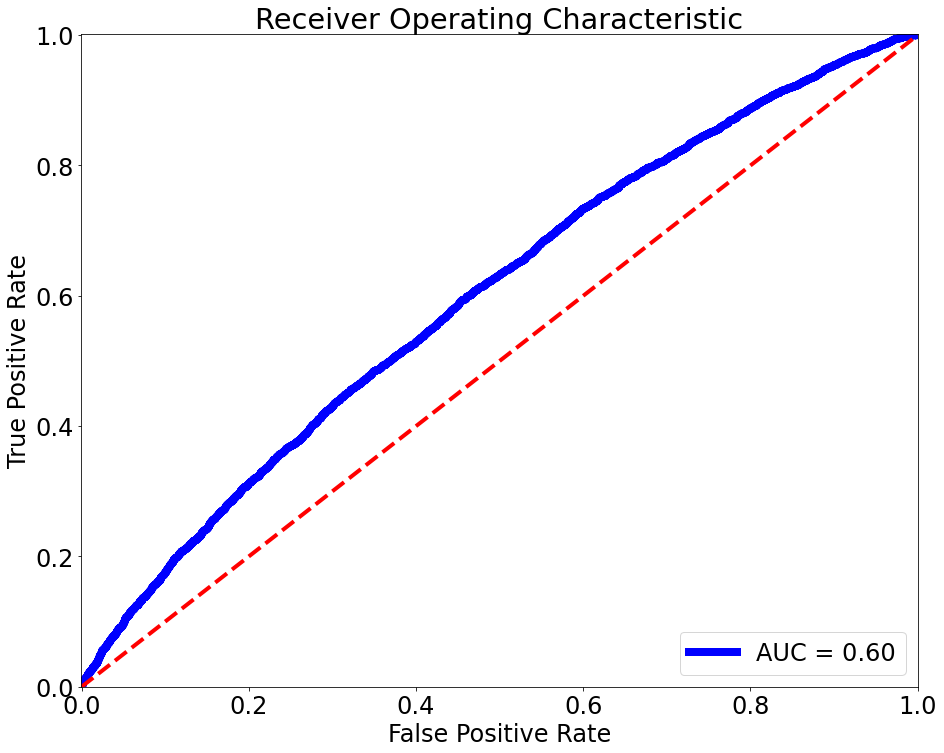

In [ ]:
##########ROC GRAPH#######

fpr, tpr, thresholds = roc_curve(tst_error_data.Class,tst_error_data.recon_error)
roc_auc = auc(fpr, tpr)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.2f'% roc_auc,linewidth = 8, color='b')
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--',linewidth = 4)
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()